# Upper and middle class workers in Ile de France

In [1]:
from pynsee import get_file_list, download_file, get_geodata

import pandas as pd
import geopandas as gpd
from pathlib import Path
from contextlib import closing

from urllib.request import Request, urlopen
import os
import py7zr
import re
import shutil

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import descartes

In [2]:
import logging
import sys
logging.basicConfig(stream=sys.stdout,
                    level=logging.INFO, 
                    format="%(message)s")

In [3]:
meta = get_file_list()
meta[meta.id.str.contains("RP_ACTRES_IRIS")].T.dropna()

Existing environment variable sirene_key used, instead of locally saved credentials
https://minio.lab.sspcloud.fr/pierrelamarche/melodi/liste_donnees.json
https://raw.githubusercontent.com/InseeFrLab/DoReMIFaSol/master/data-raw/liste_donnees.json
pynsee.download's metadata rely on volunteering contributors and their manual updates. get_file_list does not provide data from official Insee's metadata API
Consequently, please report any issue


,1497
id,RP_ACTRES_IRIS
name,RP_ACTRES_IRIS
date_ref,2017-01-01
label,"Données du Recensement de Population, données ..."
collection,RP
link,https://www.insee.fr/fr/statistiques/fichier/4...
type,xlsx
zip,True
api_rest,False
size,60768390


In [4]:
dfraw = download_file("RP_ACTRES_IRIS", silent=True)

In [5]:
# Metadata from insee.fr : https://www.insee.fr/fr/statistiques/4799323#dictionnaire
# P17_ACT1564 : nombre de personnes actives de 15 à 64 ans
# C17_ACT1564 : nombre de personnes actives de 15 à 64 ans
# C17_ACT1564_CS1 : nombre d'agriculteurs exploitants actifs de 15 à 64 ans
# C17_ACT1564_CS2 : nombre d'artisans, commerçants, chefs d'entreprise actifs de 15 à 64 ans
# C17_ACT1564_CS3 : nombre de cadres et professions intellectuelles supérieures actifs de 15 à 64 ans

In [6]:
df = dfraw[["IRIS", "COM", "REG", "DEP", "LIBCOM", "C17_ACT1564", "C17_ACT1564_CS2", "C17_ACT1564_CS3"]]
df = df[(df["REG"] == "11") ] #& ~(df["DEP"] == "77")
df["C17_ACT1564_CS2"] = pd.to_numeric(df["C17_ACT1564_CS2"])
df["C17_ACT1564_CS3"] = pd.to_numeric(df["C17_ACT1564_CS3"])
df["C17_ACT1564"] = pd.to_numeric(df["C17_ACT1564"])
df["pct"] = 100 * (df["C17_ACT1564_CS2"] + df["C17_ACT1564_CS3"]) / df["C17_ACT1564"]

df = df.reset_index(drop=True)
df

,IRIS,COM,REG,DEP,LIBCOM,C17_ACT1564,C17_ACT1564_CS2,C17_ACT1564_CS3,pct
0,751010101,75101,11,75,Paris 1er Arrondissement,520.643927,29.702144,190.009987,42.200076
1,751010102,75101,11,75,Paris 1er Arrondissement,71.145629,9.899243,36.903044,65.783784
2,751010103,75101,11,75,Paris 1er Arrondissement,107.952527,18.057574,55.539455,68.175365
3,751010104,75101,11,75,Paris 1er Arrondissement,0.000000,0.000000,0.000000,NaN
4,751010105,75101,11,75,Paris 1er Arrondissement,0.000000,0.000000,0.000000,NaN
...,...,...,...,...,...,...,...,...,...
5257,956800112,95680,11,95,Villiers-le-Bel,831.396737,54.511641,35.417896,10.816681
5258,956800113,95680,11,95,Villiers-le-Bel,885.164069,26.592849,32.183605,6.640176
5259,956800114,95680,11,95,Villiers-le-Bel,664.336730,24.113011,11.521560,5.363932
5260,956820000,95682,11,95,Villiers-le-Sec,117.460317,4.894180,24.470899,25.000000


In [7]:
shapefile = get_geodata('STATISTICALUNITS.IRIS:contours_iris', crs=3857)

Previously saved data has been used:
C:\Users\utilisateur\AppData\Local\pynsee\pynsee\Cache\pynsee\c3913eda113a24f853840db21260211e.parquet
Creation date: 2025-03-06, today
Set update=True to get the most up-to-date data


In [8]:
DF = shapefile[["code_iris", "geometry"]].merge(df, how = "right", left_on = "code_iris", right_on = "IRIS")

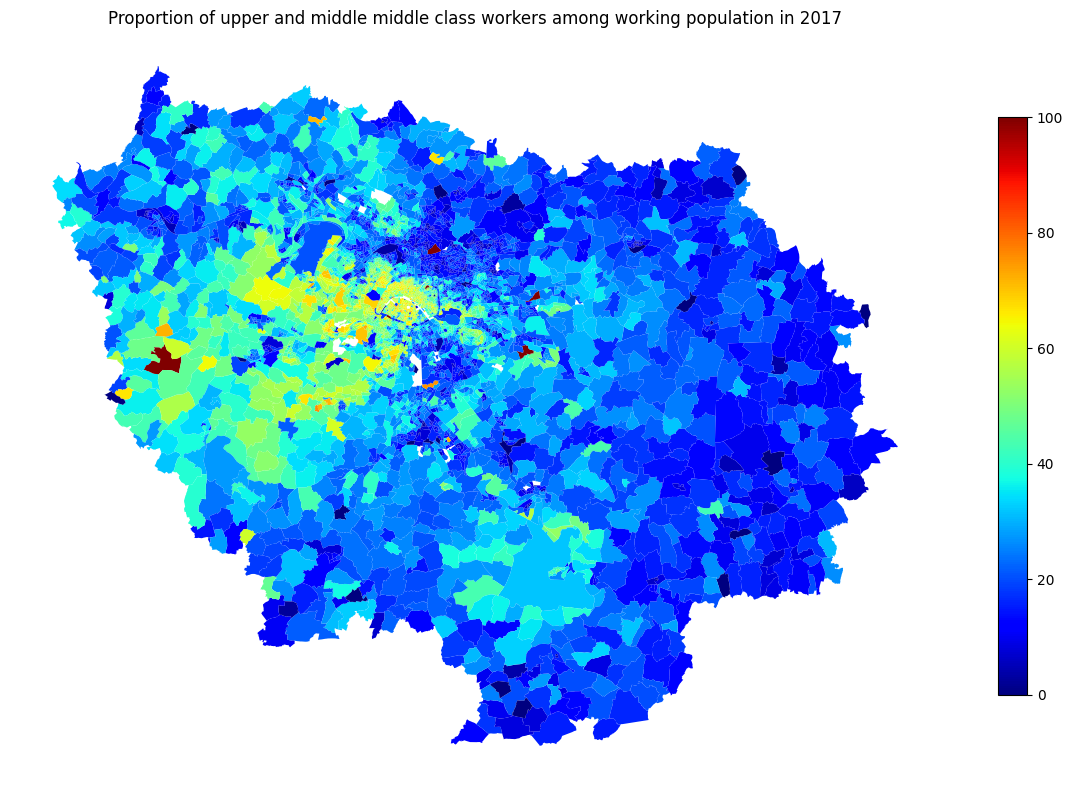

In [9]:
fig, ax = plt.subplots(1,1,figsize=[15,15])
DF.plot(column='pct', cmap=cm.jet,
    legend=True, ax=ax, legend_kwds={'shrink': 0.5})
ax.set_axis_off()
ax.set(title='Proportion of upper and middle middle class workers among working population in 2017')
plt.show()